# Epilepsy Diagnosis Approach #2
#### Using Disease Predictors to Diagnose Epilepsy

In [1]:
# Imports
import pandas as pd
import numpy as np
import re

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, KFold
from sklearn.grid_search import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score

## Data Cleaning

In [2]:
df = pd.read_csv("clean_data2.csv",delimiter=",",low_memory=False)

In [3]:
def get_predictors(df, start, end):
    # Find the start and end indices of disease columns
    start_index = list(df.columns).index(start)
    end_index = list(df.columns).index(end)
    
    disease_predictors = df.columns[start_index : end_index + 1]
    return disease_predictors

disease_predictors = get_predictors(df, "CMI:74 F1 General health", 
                                    "CMI:75 F3c) Other gynaecological problem: Seen doctor in last 12m")

In [4]:
# Remove gender specific problems
disease_predictors = disease_predictors[:-6]
print "{} disease predictors".format(len(disease_predictors))

46 disease predictors


In [5]:
# Construct a smaller DataFrame consisting of only disease predictors
target = "CMI:75 F3a) Epilepsy: Ever suffered"
x = df[disease_predictors]
x.loc[:, target] = df[target]

/Library/Python/2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Python/2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [6]:
# Remove predictors that have very few entries
threshold = 150
for col in x.columns:
    if sum(x[col].isnull()) > threshold:
        del x[col]

In [7]:
# Remove some stray predictors
del x['CMI:75 F3c) Hay fever: Seen doctor in last 12 months']
del x['CMI:74 F2 Health over last 12 months']
del x['CMI:74 F1 General health']

In [8]:
# Construct a binary response out of the three-class response

# 1 = YES
# 2 = Only when pregnant
# 3 = NO

# Encode as 2/3 -> 0, 1 -> 1
for col in x.columns:
    x.loc[:,col] = map(lambda p: 0 if p == 2 or p == 3 else p, x.loc[:,col])

In [9]:
# Drop null rows from the dataframe and check to see that we 
# still have a sufficient amount of data
x.dropna(inplace=True)
print x.shape

(11138, 16)


/Library/Python/2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [10]:
# List out the disease predictors that we have extracted
print x.columns

Index([u'CMI:75 F3a) Arthritus/rheumatism/etc: Ever suffered',
       u'CMI:75 F3a) Bronchitis: Ever suffered',
       u'CMI:75 F3a) Diabetes: Ever suffered',
       u'CMI:75 F3a) Hay fever: Ever suffered',
       u'CMI:75 F3a) Migraine: Ever suffered',
       u'CMI:75 F3a) Heart trouble: Ever suffered',
       u'CMI:75 F3a) Hernia: Ever suffered',
       u'CMI:75 F3a) Eczema/other skin problem:Ever suffered',
       u'CMI:75 F3a) Kidney/bladder trouble: Ever suffered',
       u'CMI:75 F3a) Gall bladder trouble: Eversuffered',
       u'CMI:75 F3a) Stomach trouble/indigestion: Ever suffered',
       u'CMI:75 F3a) High blood pressure: Ever suffered',
       u'CMI:75 F3a) Persistent mouth/gum trouble: Ever suffered',
       u'CMI:75 F3a) Dizziness/unsteadiness: Ever suffered',
       u'CMI:75 F3a) Cancer: Ever suffered',
       u'CMI:75 F3a) Epilepsy: Ever suffered'],
      dtype='object')


In [11]:
# Define some labels for the diseases to display graphically
ticklabels = [col.split(") ")[1].split(":")[0] for col in x.columns]

## Data Exploration

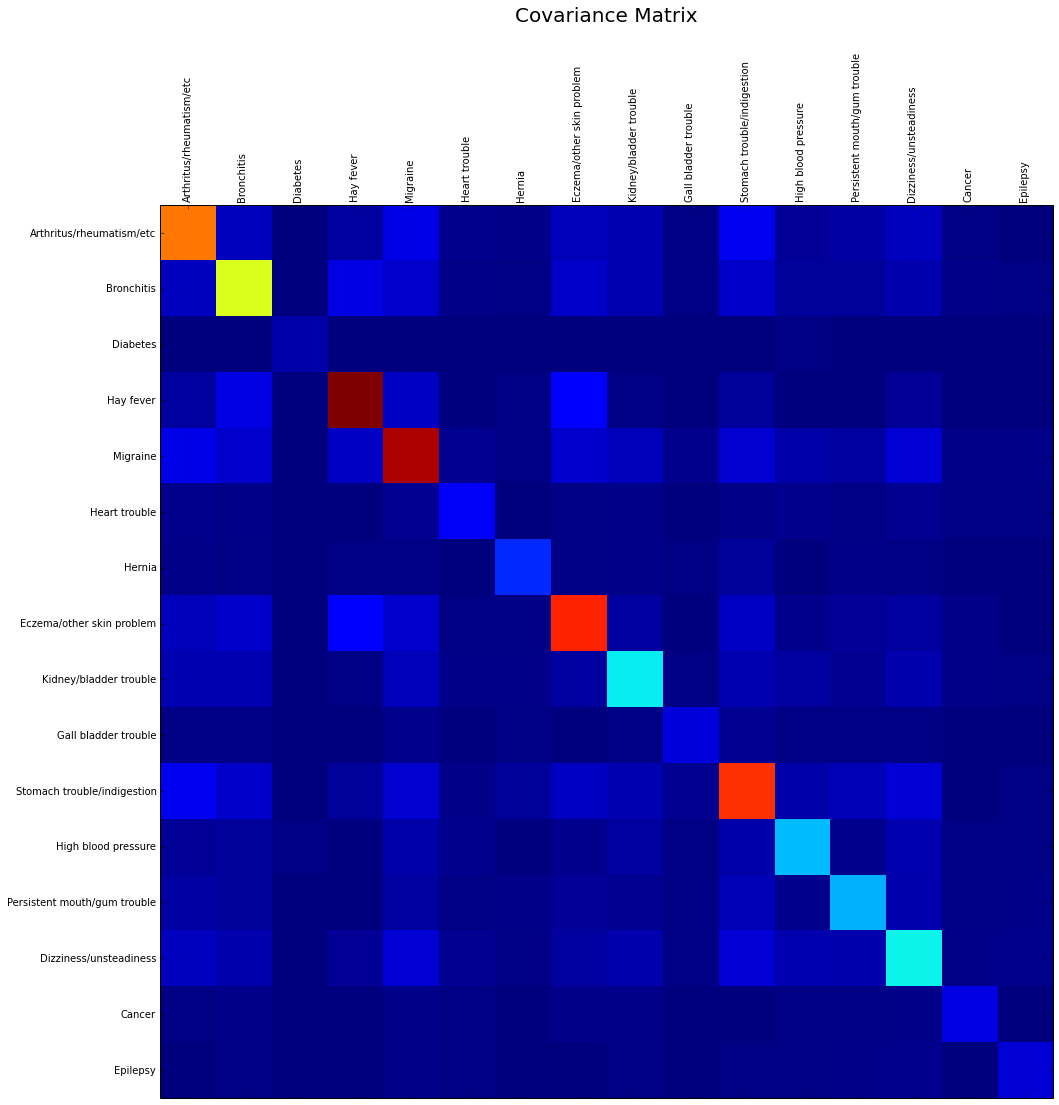

In [12]:
# Covariance Matrix
cov = x.cov()
fig, ax = plt.subplots(figsize=(16, 16))
ax.matshow(cov)
plt.xticks(range(len(x.columns)), ticklabels, rotation=90)
plt.yticks(range(len(x.columns)), ticklabels)
ax.set_yticklabels(ticklabels)

plt.title("Covariance Matrix", y=1.2, size=20)
plt.show()

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


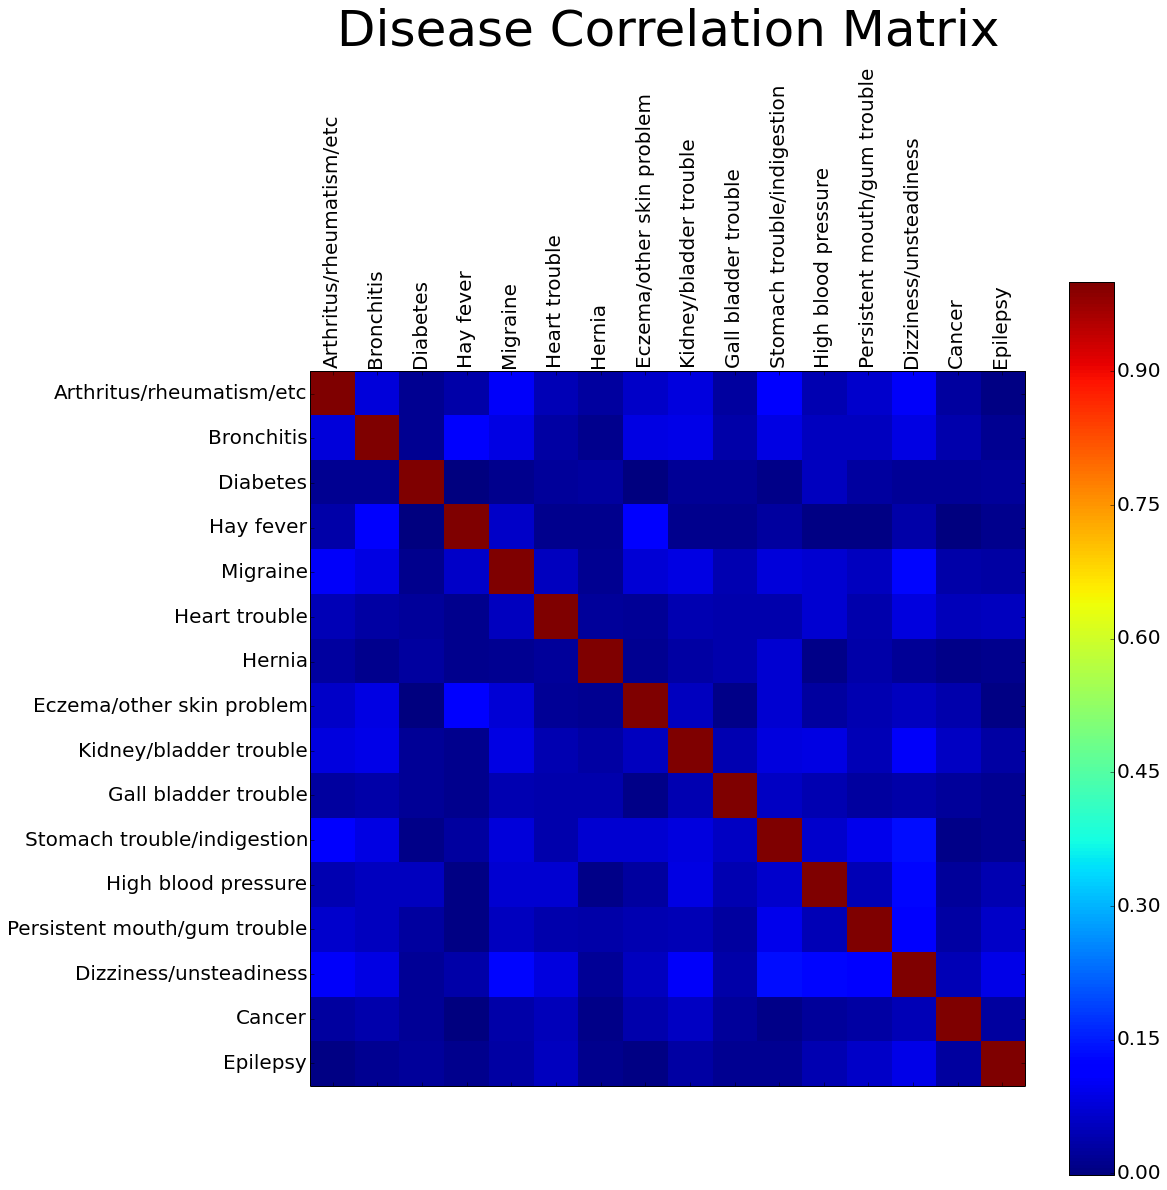

In [13]:
# Correlation Matrix
corr = x.corr()
fig, ax = plt.subplots(figsize=(16, 16))
mat = ax.matshow(corr)
plt.xticks(range(len(x.columns)), ticklabels, rotation=90, size=20)
plt.yticks(range(len(x.columns)), ticklabels)
ax.set_yticklabels(ticklabels, size=20)

plt.title("Disease Correlation Matrix", y=1.45, size=50)
cbar = plt.colorbar(mat)
cbar.ax.tick_params(labelsize=20) 
plt.savefig('Disease_Correlation.eps', format='eps', dpi=100, bbox_inches='tight')
plt.show()

## Modeling

In [14]:
# Split the data into predictors and response
y = x[target]
x = x.drop(target, axis=1)

In [15]:
# Define some helper functions that will give us the accuracy on healthy and epileptic classes
def accuracy_epilepsy(preds, y):
    return sum(preds[y.values == 1] == 1) / float(len(y.values[y.values == 1]))

def accuracy_healthy(preds, y):
    return sum(preds[y.values == 0] == 0) / float(len(y.values[y.values == 0]))

In [16]:
def cross_val_score(x, y, estimator, kf):
    score = 0
    e_score = 0
    h_score = 0

    for tr, te in kf:
        estimator.fit(x.iloc[tr, :], y.iloc[tr])
        score += estimator.score(x.iloc[te, :], y.iloc[te])
        
        preds = estimator.predict(x.iloc[te, :])
        e_score += accuracy_epilepsy(preds, y.iloc[te])
        h_score += accuracy_healthy(preds, y.iloc[te])
        
    print "Overall score: {}".format(score / float(kf.n_folds))
    print "Epilepsy score: {}".format(e_score / float(kf.n_folds))
    print "Healthy score: {}".format(h_score / float(kf.n_folds))

In [17]:
kfold = KFold(len(x), n_folds=5, shuffle=True)

#### Random Forest Classifier

In [18]:
parameters = {
    "max_depth": [8, 9, 10],
    "n_estimators": [10, 15, 20],
    "max_features": [5, 10, 15],
    "class_weight": [{1: 80}, {1: 100}, {1: 120}]
}
rf = RandomForestClassifier()
rf_gs = GridSearchCV(rf, parameters, scoring="roc_auc", n_jobs=-1)
rf_gs.fit(x, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 15, 20], 'max_features': [5, 10, 15], 'max_depth': [8, 9, 10], 'class_weight': [{1: 80}, {1: 100}, {1: 120}]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [19]:
cross_val_score(x, y, rf_gs.best_estimator_, kfold)

Overall score: 0.897023473141
Epilepsy score: 0.170175953079
Healthy score: 0.90613420462


#### Logistic Regression

In [20]:
parameters = {
    "C": [10 ** i for i in range(-3, 4)],
    "class_weight": [{1: 80}, {1: 100}, {1: 120}]
}

reg = LogisticRegression()
reg_gs = GridSearchCV(reg, parameters, scoring="roc_auc", n_jobs=-1)
reg_gs.fit(x, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{1: 80}, {1: 100}, {1: 120}]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [21]:
cross_val_score(x, y, reg_gs.best_estimator_, kfold)

Overall score: 0.676870688522
Epilepsy score: 0.508315458735
Healthy score: 0.678938820193


#### KNN

In [22]:
parameters = {
   "n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "weights": ["uniform", "distance"]
}

knn = KNeighborsClassifier()
knn_gs = GridSearchCV(knn, parameters, scoring="roc_auc", n_jobs=-1)
knn_gs.fit(x, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [23]:
cross_val_score(x, y, knn_gs.best_estimator_, kfold)

Overall score: 0.987160714876
Epilepsy score: 0.0204992319508
Healthy score: 0.9991828047


#### Plot ROC curves to demonstrate results

We run this code many times to pick up the general trends of the ROC curves.

[ 0.   0.   0.  ...,  0.   0.2  0. ]


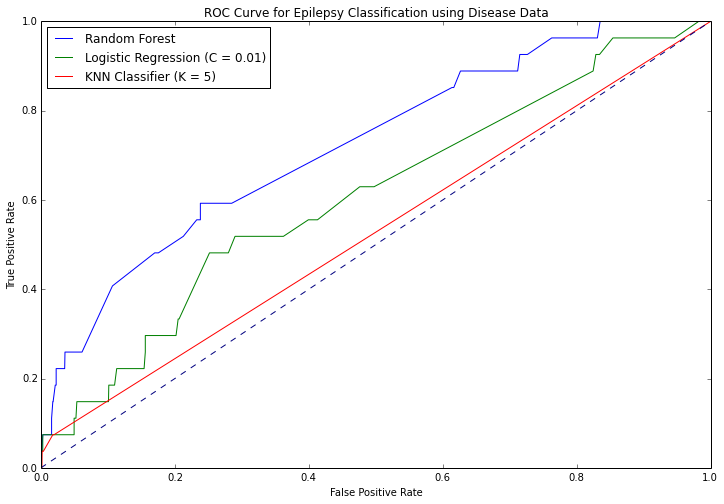

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y)

best_rf = rf_gs.best_estimator_
best_reg = reg_gs.best_estimator_
best_knn = knn_gs.best_estimator_

best_knn.fit(x_train, y_train)
best_reg.fit(x_train, y_train)
best_knn.fit(x_train, y_train)

preds1 = best_rf.predict_proba(x_test)[:,1]
preds2 = best_reg.predict_proba(x_test)[:,1]
preds3 = best_knn.predict_proba(x_test)[:,1]

print preds3

fig, ax = plt.subplots(figsize=(12,8))
fpr, tpr, thresholds = roc_curve(y_test, preds1, pos_label=1)
plt.plot(fpr, tpr, label="Random Forest")
fpr, tpr, thresholds = roc_curve(y_test, preds2, pos_label=1)
plt.plot(fpr, tpr, label="Logistic Regression (C = 0.01)")
fpr, tpr, thresholds = roc_curve(y_test, preds3, pos_label=1)
plt.plot(fpr, tpr, label="KNN Classifier (K = 5)")
plt.plot([0, 1], [0, 1], color='navy', lw=1.0, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC Curve for Epilepsy Classification using Disease Data")
plt.savefig('Disease_ROC.png', format='png', dpi=100)

### Print out important features

In [67]:
# Logistic regression coeffs
reg_coeffs = [(best_reg.coef_[0][i], x.columns[i]) for i in range(len(x.columns))]
reg_coeffs = sorted(reg_coeffs, key = lambda c: abs(c[0]))
for coeff in reg_coeffs:
    print coeff

(-0.012026601798145452, 'CMI:75 F3a) Bronchitis: Ever suffered')
(-0.013434561030992359, 'CMI:75 F3a) Eczema/other skin problem:Ever suffered')
(-0.016369023411124145, 'CMI:75 F3a) Diabetes: Ever suffered')
(-0.034900801835832093, 'CMI:75 F3a) Stomach trouble/indigestion: Ever suffered')
(0.071350217622585421, 'CMI:75 F3a) Hay fever: Ever suffered')
(0.10619626176958259, 'CMI:75 F3a) Cancer: Ever suffered')
(-0.19275125352276307, 'CMI:75 F3a) Hernia: Ever suffered')
(0.20247049971056441, 'CMI:75 F3a) Heart trouble: Ever suffered')
(-0.210516485305283, 'CMI:75 F3a) Gall bladder trouble: Eversuffered')
(0.31577364890092313, 'CMI:75 F3a) Migraine: Ever suffered')
(-0.32520178125327875, 'CMI:75 F3a) Arthritus/rheumatism/etc: Ever suffered')
(0.38491257390547856, 'CMI:75 F3a) High blood pressure: Ever suffered')
(0.43795386275043274, 'CMI:75 F3a) Kidney/bladder trouble: Ever suffered')
(0.75286821131108506, 'CMI:75 F3a) Persistent mouth/gum trouble: Ever suffered')
(0.86809260373795338, 'CM

In [68]:
# Random forest importances
rf_imps = [(best_rf.feature_importances_[i], x.columns[i]) for i in range(len(x.columns))]
rf_imps = sorted(rf_imps, key = lambda c: c[0])

for imp in rf_imps:
    print imp

(0.00090759542160592972, 'CMI:75 F3a) Diabetes: Ever suffered')
(0.0064353911038774157, 'CMI:75 F3a) Gall bladder trouble: Eversuffered')
(0.0084791597640861242, 'CMI:75 F3a) Cancer: Ever suffered')
(0.018928544928446246, 'CMI:75 F3a) Hernia: Ever suffered')
(0.04692282464153396, 'CMI:75 F3a) Heart trouble: Ever suffered')
(0.050963375475410785, 'CMI:75 F3a) Kidney/bladder trouble: Ever suffered')
(0.06470908442817308, 'CMI:75 F3a) Bronchitis: Ever suffered')
(0.065933217977450262, 'CMI:75 F3a) Eczema/other skin problem:Ever suffered')
(0.069335368055927146, 'CMI:75 F3a) High blood pressure: Ever suffered')
(0.084061120181315313, 'CMI:75 F3a) Migraine: Ever suffered')
(0.086010680398687617, 'CMI:75 F3a) Hay fever: Ever suffered')
(0.091036687000681862, 'CMI:75 F3a) Persistent mouth/gum trouble: Ever suffered')
(0.097092128068120273, 'CMI:75 F3a) Stomach trouble/indigestion: Ever suffered')
(0.098326445951800096, 'CMI:75 F3a) Arthritus/rheumatism/etc: Ever suffered')
(0.2108583766028838